## TWITTER SENTIMENT ANALYSIS

In [99]:
#import libraries 
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt_tab')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mannu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mannu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [100]:
#load the data
df = pd.read_csv("judge-1377884607_tweet_product_company.csv", encoding= 'latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [101]:
#print the columns 
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [102]:
#rename the columns
df = df.rename(columns= {
    'tweet_text': 'tweet',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'
})
df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [103]:
df.shape

(9093, 3)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


### From the info above column tweet has one missing value while the product column has alot of missing values

In [105]:
#drop Nan in tweets
df.dropna(subset= ['tweet'], inplace=True)

In [106]:
#drop duplicates
df.drop_duplicates(inplace=True)

In [107]:
df.shape

(9070, 3)

In [108]:
#check missing values
df.isna().sum()

tweet           0
product      5788
sentiment       0
dtype: int64

## for the missing values in product we fill with *undefined*

In [109]:
df['product'] = df['product'].fillna('undefined')

In [110]:
df.isna().sum()

tweet        0
product      0
sentiment    0
dtype: int64

## EDA

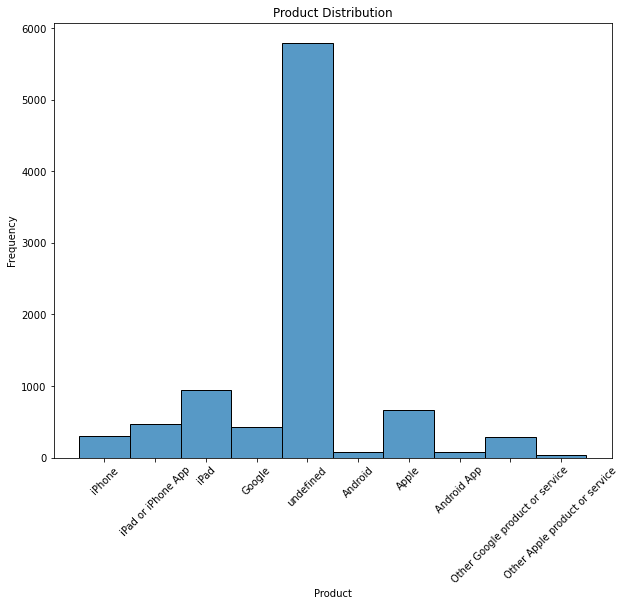

In [111]:
# Product distribution 
fig, ax = plt.subplots(figsize = (10, 8))
sns.histplot(df['product'])
ax.set_title('Product Distribution')
ax.set_xlabel('Product')
ax.set_ylabel('Frequency')
ax.tick_params(axis ='x', rotation = 45)
plt.show()

### There's high class imbalance and that may affect the analysis

In [112]:
#let's create a copy of our data
df_copy = df.copy()

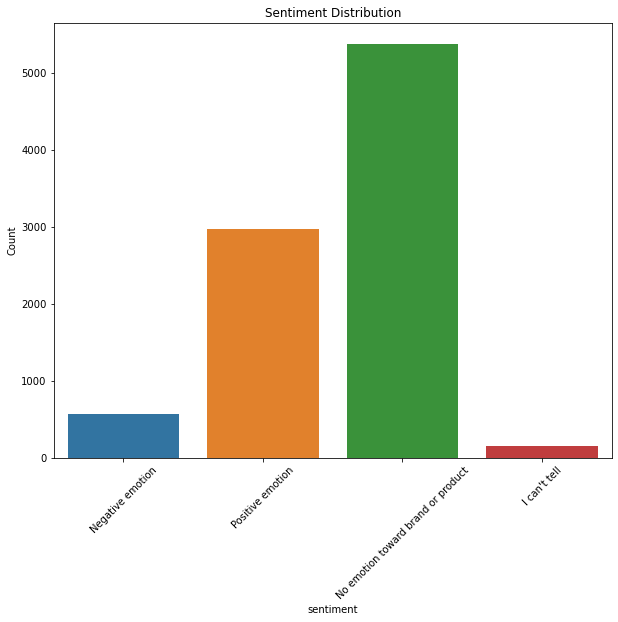

In [113]:
#sentiment class distribution
fig, ax = plt.subplots(figsize = (10,8))
sns.countplot(data = df, x = 'sentiment', ax=ax)
ax.set_title('Sentiment Distribution')
ax.set_xlabel('sentiment')
ax.set_ylabel('Count')
ax.tick_params(axis = 'x', rotation= 45)
plt.show()

In [114]:
#create a new column showing the number of characters in each tweet
df['Chars'] = df['tweet'].apply(len)

In [115]:
df.head()

,tweet,product,sentiment,Chars
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131


In [116]:
#create new columns showing the number of words and sentences in each tweet
df['words'] = df['tweet'].apply(lambda tweet:nltk.word_tokenize(tweet)).apply(len)
df['sentence'] = df['tweet'].apply(lambda tweet:nltk.sent_tokenize(tweet)).apply(len)

df.head()

,tweet,product,sentiment,Chars,words,sentence
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,32,5
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,29,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,20,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,21,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,29,1


### Preprocessing

In [117]:
df.describe()

,Chars,words,sentence
count,9070.000000,9070.000000,9070.000000
mean,104.959647,24.417420,1.878611
std,27.202956,6.503311,0.939999
min,11.000000,3.000000,1.000000
25%,86.000000,20.000000,1.000000
50%,109.000000,25.000000,2.000000
75%,126.000000,29.000000,2.000000
max,178.000000,49.000000,7.000000


In [118]:
from collections import Counter

def most_frequent_words(df, sentiment, top_n=20):
    """
    Get the most frequent words for a given sentiment.
    
    Parameters:
    df (DataFrame): The DataFrame containing tweets and sentiments.
    sentiment (str): The sentiment to filter by.
    top_n (int): The number of top words to return.
    
    Returns:
    list: A list of the most frequent words.
    """
    
    words = ' '.join(df[df['sentiment'] == sentiment]['tweet']).split()
    most_common = Counter(words).most_common(top_n)
    return [word for word, count in most_common]

# Get most frequent words for each sentiment
sentiments = df['sentiment'].unique()
most_frequent_words_dict = {sentiment: most_frequent_words(df, sentiment) for sentiment in sentiments}

for sentiment, words in most_frequent_words_dict.items():
    print(f"Most frequent words for sentiment '{sentiment}': {', '.join(words)}")
    

Most frequent words for sentiment 'Negative emotion': #sxsw, @mention, the, to, #SXSW, a, is, RT, at, of, iPad, I, for, in, Google, {link}, on, iPhone, my, and
Most frequent words for sentiment 'Positive emotion': @mention, the, #sxsw, {link}, #SXSW, to, at, RT, for, a, iPad, of, is, in, Apple, and, Google, on, I, 2
Most frequent words for sentiment 'No emotion toward brand or product': @mention, {link}, #sxsw, #SXSW, the, to, RT, at, for, a, in, Google, of, and, iPad, Apple, is, on, -, &amp;
Most frequent words for sentiment 'I can't tell': @mention, #sxsw, #SXSW, the, to, {link}, at, a, for, is, of, Google, RT, iPad, I, on, in, Apple, my, be


In [119]:
#clean the data
def data_cleaning(tweet):
     return re.sub(r"http\S+|www\S+|@\w+|#\w+|[^a-zA-Z\s]", "", tweet.lower())

df['clean_tweet'] = df['tweet'].apply(data_cleaning)
df.head()

,tweet,product,sentiment,Chars,words,sentence,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,32,5,i have a g iphone after hrs tweeting at it ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,29,3,know about awesome ipadiphone app that youl...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,20,2,can not wait for also they should sale them...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,21,2,i hope this years festival isnt as crashy as ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,29,1,great stuff on fri marissa mayer google tim ...


In [120]:
#tokenize the clean_tweet
def tokenizer_unit(tweet):
    tokens = word_tokenize(tweet)

    return tokens

tokenizer_unit(df['clean_tweet'].head().to_string(index=False))

['i',
 'have',
 'a',
 'g',
 'iphone',
 'after',
 'hrs',
 'tweeting',
 'at',
 'it',
 '...',
 'know',
 'about',
 'awesome',
 'ipadiphone',
 'app',
 'that',
 'youl',
 '...',
 'can',
 'not',
 'wait',
 'for',
 'also',
 'they',
 'should',
 'sale',
 'them',
 '...',
 'i',
 'hope',
 'this',
 'years',
 'festival',
 'isnt',
 'as',
 'crashy',
 'as',
 '...',
 'great',
 'stuff',
 'on',
 'fri',
 'marissa',
 'mayer',
 'google',
 'tim',
 '...']

In [121]:

# remove all the tokens that are not alphaphetic
def remove_non_alpha (tokens):
    return[token for token in tokens if token.isalpha()]

df['tokens'] = df['clean_tweet'].astype(str).apply(tokenizer_unit).apply(remove_non_alpha)

In [122]:
df.shape

(9070, 8)

In [123]:
#remove stop words
def remove_stopwords(tokens):
    stop_words = set(stopwords. words('english'))
    return [token for token in tokens if token not in stop_words]

df['tokens'] = df['tokens'].apply(remove_stopwords)

In [124]:
df.head()

,tweet,product,sentiment,Chars,words,sentence,clean_tweet,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,32,5,i have a g iphone after hrs tweeting at it ...,"[g, iphone, hrs, tweeting, dead, need, upgrade..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,29,3,know about awesome ipadiphone app that youl...,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,20,2,can not wait for also they should sale them...,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,21,2,i hope this years festival isnt as crashy as ...,"[hope, years, festival, isnt, crashy, years, i..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,29,1,great stuff on fri marissa mayer google tim ...,"[great, stuff, fri, marissa, mayer, google, ti..."


## Stemming

In [125]:
from nltk.stem import PorterStemmer

def stem_words(tokens):
    porter = PorterStemmer()
    return[porter.stem(token) for token in tokens]

df['tokens'] =df['tokens'].apply(stem_words)

In [126]:
df.head()

,tweet,product,sentiment,Chars,words,sentence,clean_tweet,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,32,5,i have a g iphone after hrs tweeting at it ...,"[g, iphon, hr, tweet, dead, need, upgrad, plug..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,29,3,know about awesome ipadiphone app that youl...,"[know, awesom, ipadiphon, app, youll, like, ap..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,20,2,can not wait for also they should sale them...,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,21,2,i hope this years festival isnt as crashy as ...,"[hope, year, festiv, isnt, crashi, year, iphon..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,29,1,great stuff on fri marissa mayer google tim ...,"[great, stuff, fri, marissa, mayer, googl, tim..."


## Vectorization 

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer

#convert tokens back to text
def tokens_to_text(tokens):
    return ' '.join(tokens)

df['processsed_tweet'] = df['tokens'].apply(tokens_to_text)

In [129]:
df.head()

,tweet,product,sentiment,Chars,words,sentence,clean_tweet,tokens,processsed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,32,5,i have a g iphone after hrs tweeting at it ...,"[g, iphon, hr, tweet, dead, need, upgrad, plug...",g iphon hr tweet dead need upgrad plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,29,3,know about awesome ipadiphone app that youl...,"[know, awesom, ipadiphon, app, youll, like, ap...",know awesom ipadiphon app youll like appreci d...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,20,2,can not wait for also they should sale them...,"[wait, also, sale]",wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,21,2,i hope this years festival isnt as crashy as ...,"[hope, year, festiv, isnt, crashi, year, iphon...",hope year festiv isnt crashi year iphon app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,29,1,great stuff on fri marissa mayer google tim ...,"[great, stuff, fri, marissa, mayer, googl, tim...",great stuff fri marissa mayer googl tim oreill...


## Modelling Functions 

In [184]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, classification_report, precision_score, recall_score

#nltk resources 
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mannu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mannu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [131]:
X_text = df['processsed_tweet'].fillna(' ')

#initialize the vectorizer
vectorizer = TfidfVectorizer( max_features=5000, stop_words='english')

#fit and transform
X =vectorizer.fit_transform(X_text)

## Encoding target labels

In [132]:
from sklearn.preprocessing import LabelEncoder

#initialize the ecoder the fit the data
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])

#show label mapping
print('Label Mapping')
for label, encoded in zip(le.classes_, le.transform(le.classes_)):
    print(f"{label} -> {encoded}")

#define y
y= df['sentiment_encoded']

Label Mapping
I can't tell -> 0
Negative emotion -> 1
No emotion toward brand or product -> 2
Positive emotion -> 3


## Train and Split

In [140]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2, stratify=y)

print(f'Training shape:', X_train.shape, y_train.shape)
print(f'Test Shape: ', X_test.shape, y_test.shape)

Training shape: (7256, 5000) (7256,)
Test Shape:  (1814, 5000) (1814,)


## Pipeline for each model

In [141]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [142]:
#define classifiers 
models = { 
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'KNN':KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss', random_state = 42)
}

#define pipelines
pipeline = {}

for name, clf in models.items():
    pipeline[name] = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('clf', clf)
    ])

#  Now pipelines has: 
# 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'KNN', 'XGBoost'
print(" Pipelines created:", list(pipeline.keys()))


 Pipelines created: ['Random Forest', 'Logistic Regression', 'Naive Bayes', 'KNN', 'XGBoost']


### Logistic Regresssion


In [145]:
log_reg = Pipeline([
    ('classifier', LogisticRegression(max_iter=100, random_state=42))
])

In [148]:
#train the model
log_reg.fit(X_train, y_train)

#predict
y_pred_log_reg = log_reg.predict(X_test)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred_log_reg)
log_reg_precion, log_reg_recall, log_reg_f1score, _ = precision_recall_fscore_support(y_test, y_pred_log_reg, average='weighted')

#detailed report
print('n\Detailed Classification Report:')
print(classification_report(y_test, y_pred_log_reg))


n\Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       1.00      0.06      0.12       114
           2       0.69      0.88      0.77      1075
           3       0.63      0.46      0.53       594

    accuracy                           0.68      1814
   macro avg       0.58      0.35      0.36      1814
weighted avg       0.68      0.68      0.64      1814



c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\M

### Hyperparameter tuning using GridSearchCv

In [149]:
from sklearn.model_selection import GridSearchCV

In [153]:
#define the parameter grid
params_grid = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

#set up the GridSearchCV
grid_search = GridSearchCV(
    estimator= LogisticRegression(max_iter=100, random_state=42),
    param_grid= params_grid,
    scoring= 'f1_weighted',
    cv = 3,
    verbose= 2,
    n_jobs=1
)

#fit
grid_search.fit(X_train, y_train)

print('n\Best hyperparameters found:')

for param, value in grid_search.best_params_.items():
    print(f'- {param} : {value}')


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..........................C=0.01, class_weight=None; total time=   0.2s
[CV] END ..........................C=0.01, class_weight=None; total time=   0.1s
[CV] END ..........................C=0.01, class_weight=None; total time=   0.1s
[CV] END ......................C=0.01, class_weight=balanced; total time=   0.2s
[CV] END ......................C=0.01, class_weight=balanced; total time=   0.0s
[CV] END ......................C=0.01, class_weight=balanced; total time=   0.2s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.3s
[CV] END ...........................C=0.1, class_weight=None; total time=   1.1s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.4s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.2s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.2s
[CV] END .......................C=0.1, class_weig

c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................C=1, class_weight=balanced; total time=   0.7s


c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................C=1, class_weight=balanced; total time=   0.8s


c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................C=1, class_weight=balanced; total time=   0.8s


c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................C=10, class_weight=None; total time=   0.7s


c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................C=10, class_weight=None; total time=   0.6s


c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................C=10, class_weight=None; total time=   0.6s


c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........................C=10, class_weight=balanced; total time=   0.9s


c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........................C=10, class_weight=balanced; total time=   0.7s


c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........................C=10, class_weight=balanced; total time=   0.6s
n\Best hyperparameters found:
- C : 10
- class_weight : None


c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [157]:

#tuning on test set
y_pred = grid_search.predict(X_test)

#evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision, recall, flscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

#detailed classification report
print("n\Detailed Classification Report:")
print(classification_report(y_test,y_pred))

n\Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.48      0.26      0.34       114
           2       0.71      0.81      0.75      1075
           3       0.60      0.52      0.56       594

    accuracy                           0.67      1814
   macro avg       0.45      0.40      0.41      1814
weighted avg       0.65      0.67      0.65      1814



## Random Forest Model

In [159]:
#define the model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight= 'balanced'
)
#fit the model/train
rf_model.fit(X_train, y_train)

#predict the model
y_pred_rf_model = rf_model.predict(X_test)

#evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf_model)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_rf_model)

#detailed report
print('n\Detailed Report:')
print(classification_report(y_test, y_pred_rf_model))


n\Detailed Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.61      0.20      0.30       114
           2       0.68      0.86      0.76      1075
           3       0.63      0.43      0.51       594

    accuracy                           0.67      1814
   macro avg       0.48      0.37      0.39      1814
weighted avg       0.65      0.67      0.64      1814



In [162]:
#  Grid search

#  Define parameter grid (only RandomForest hyperparameters)
param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'class_weight': [None, 'balanced']
}
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2
)

#  Fit on pre-vectorized data
grid_search_rf.fit(X_train, y_train)

print(" Best RF Parameters:")
print(grid_search_rf.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
 Best RF Parameters:
{'class_weight': None, 'max_depth': None, 'n_estimators': 300}


In [163]:
#  Predict with best model
y_pred_rf_best = grid_search_rf.predict(X_test)

#  Evaluate tuned model
accuracy = accuracy_score(y_test, y_pred_rf_best)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf_best, average='weighted')

print(" Tuned Random Forest Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\n Detailed Classification Report:\n")
print(classification_report(y_test, y_pred_rf_best))


 Tuned Random Forest Performance:
Accuracy : 0.6803
Precision: 0.6704
Recall   : 0.6803
F1 Score : 0.6549

 Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.70      0.20      0.31       114
           2       0.69      0.87      0.77      1075
           3       0.66      0.46      0.54       594

    accuracy                           0.68      1814
   macro avg       0.51      0.38      0.41      1814
weighted avg       0.67      0.68      0.65      1814



## K-Nearests Neigbours(KNN) Model

In [166]:
from sklearn.neighbors import KNeighborsClassifier

#instatiate the model
knn = KNeighborsClassifier(n_neighbors= 5, n_jobs= -1)

#fit the model
knn.fit(X_train, y_train)

#predict
y_pred_knn = knn.predict(X_test)

#evaluate the model
accuracy = accuracy_score(y_test, y_pred_knn)

#detailed report
print('n\Classification Report:')
print(classification_report(y_test, y_pred_knn))

n\Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.62      0.07      0.13       114
           2       0.61      0.97      0.75      1075
           3       0.66      0.12      0.20       594

    accuracy                           0.62      1814
   macro avg       0.47      0.29      0.27      1814
weighted avg       0.62      0.62      0.52      1814



c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Tuning KNN witj GridSearchCV

In [175]:
param_grid_knn = {
    'n_neighbors': [3,5,7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
#gridsearch model
grid_search_knn = GridSearchCV(
    estimator= knn,
    param_grid= param_grid_knn,
    scoring='f1_weighted',
    cv = 3,
    verbose= 1,
    n_jobs=-1
)

#fit 
grid_search_knn.fit(X_train, y_train)

#predict
y_pred_grid_search_knn = grid_search_knn.predict(X_test)

#evaluate
accuracy = accuracy_score (y_test, y_pred_grid_search_knn)
print(f'Accuracy :', accuracy)

#Detailed report
print('Detailed Report:')
print(classification_report(y_test, y_pred_grid_search_knn))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Accuracy : 0.6466372657111357
Detailed Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.67      0.21      0.32       114
           2       0.65      0.92      0.76      1075
           3       0.67      0.27      0.39       594

    accuracy                           0.65      1814
   macro avg       0.50      0.35      0.37      1814
weighted avg       0.64      0.65      0.60      1814



## Naive Bayes Classifier

In [177]:
from sklearn.naive_bayes import MultinomialNB

nb_model = Pipeline([
    ('tdif', TfidfVectorizer(max_features= 5000, stop_words= 'english')),
    ('clf', MultinomialNB)
])

#train
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

#predict
y_pred_nb = nb_model.predict(X_test)

#evaluate
accuracy = accuracy_score(y_test, y_pred_nb)

#Detailed report
print('\nDetailed Report :')
print(classification_report(y_test, y_pred_nb))


Detailed Report :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.50      0.02      0.03       114
           2       0.65      0.92      0.76      1075
           3       0.63      0.30      0.41       594

    accuracy                           0.65      1814
   macro avg       0.45      0.31      0.30      1814
weighted avg       0.62      0.65      0.59      1814



c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mannu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



### Hyperparameter tuning of Naives Bayes using GridSearchCv

In [179]:
param_gridsearchCv_nb = {
    'alpha': [0.1, 0.5, 1.0]
}

#GridSearchCV
grid_search_nb  = GridSearchCV(
    estimator= nb_model,
    param_grid= param_gridsearchCv_nb,
    scoring= 'f1_weighted',
    cv = 3,
    n_jobs= -1,
    verbose= 2
)

#fit 
grid_search_nb.fit(X_train, y_train)

#predict
y_pred_grid_search_nb = grid_search_nb.predict(X_test)

#evaluate
accuracy = accuracy_score (y_test, y_pred_grid_search_nb)
print(f'Accuracy: ', accuracy)

#Detailed Report
print('n\Detailed Report:')
print(classification_report(y_test, y_pred_grid_search_nb))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


Accuracy:  0.6460859977949284
n\Detailed Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.42      0.19      0.27       114
           2       0.68      0.83      0.75      1075
           3       0.57      0.44      0.50       594

    accuracy                           0.65      1814
   macro avg       0.42      0.36      0.38      1814
weighted avg       0.62      0.65      0.62      1814



## XGBoost Classifier

In [180]:
#define the model
xgboost_model = XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss', random_state = 42)

#fit the model
xgboost_model.fit(X_train, y_train)

#predict
y_pred_xgboost = xgboost_model.predict(X_test)

#evaluate
accuracy = accuracy_score(y_test, y_pred_xgboost)
print(f'Accuracy: ', accuracy)

#Detailed Report
print(f'Detailed Report: ')
print(classification_report(y_test, y_pred_xgboost))

Accuracy:  0.6714443219404631
Detailed Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.47      0.12      0.19       114
           2       0.68      0.90      0.77      1075
           3       0.66      0.40      0.50       594

    accuracy                           0.67      1814
   macro avg       0.45      0.36      0.37      1814
weighted avg       0.65      0.67      0.63      1814



### Hyperparameter Tuning with GridSearchCv

In [181]:
param_gridsearchCv_xg = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3]
}

#Set GridSearchCv
grid_search_xg = GridSearchCV(
    estimator= xgboost_model,
    param_grid= param_gridsearchCv_xg,
    scoring= 'f1_weighted',
    cv = 3,
    n_jobs= -1,
verbose= 2
)

#fit the data
grid_search_xg.fit(X_train, y_train)

#get best model
best_xbg = grid_search_xg.best_estimator_

#predict
y_pred_best_xgb = best_xbg.predict(X_test)

#evaluate
accuracy = accuracy_score(y_test, y_pred_best_xgb)
print(f'Accuracy: ', accuracy)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Accuracy:  0.6708930540242558


## Comparing Models

In [185]:

# Fit raw models (no pipeline)
logreg_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
nb_model = MultinomialNB()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

logreg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Compare
models = {
    'Logistic Regression': logreg_model,
    'Random Forest': rf_model,
    'Naive Bayes': nb_model,
    'XGBoost': xgb_model
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })


metrics_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1 Score
1        Random Forest  0.681918   0.671033  0.681918  0.656620
0  Logistic Regression  0.678060   0.679586  0.678060  0.641073
3              XGBoost  0.671444   0.647800  0.671444  0.634607
2          Naive Bayes  0.646086   0.622763  0.646086  0.587869


 **Insights:**
- **Random Forest** achieved the highest accuracy (≈68%) and best F1 score (≈0.66).
- **Logistic Regression** had the highest precision but slightly lower F1.
- **XGBoost** and **Naive Bayes** performed slightly worse overall.
- All models still show room for improvement, especially in minority class predictions.

In [189]:
# save model 
import joblib
import os


os.makedirs('./models', exist_ok=True)



joblib.dump(rf_model, './models/random_forest_model.pkl')

['./models/random_forest_model.pkl']